In [1]:
import pandas as pd
import numpy as np
import time
import gc
gc.collect()

0

In [2]:
dataset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/Case Labeling/mimic_df.csv.gz', index_col = 0, compression='gzip')
embset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/supervised_contrastive_learning/embedding_data.csv.gz', index_col = 0, compression='gzip')
total_dataset = pd.concat([dataset.reset_index(drop=True), embset.drop(['subject_id', 'stay_id', 'hadm_id', '43'], axis = 1).reset_index(drop=True)], axis = 1)

In [3]:
preproc = pd.read_csv("/Users/DAHS/MIMIC-IV-Data-Pipeline/mimiciv/2.2/icu/procedureevents.csv.gz", index_col = 0, compression='gzip')
demo = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/data/cohort/cohort_icu_mortality_0_.csv.gz', index_col = 0, compression='gzip')
new = preproc.merge(demo[['intime', 'stay_id']], how='inner', left_on='stay_id', right_on='stay_id')

new.intime = pd.to_datetime(new.intime)
new.starttime = pd.to_datetime(new.starttime)
new.endtime = pd.to_datetime(new.endtime)

new['start_time'] = new['starttime'] - new['intime']
new['end_time'] = new['endtime'] - new['intime']

new['start_time']=new['start_time'].astype(str)
new['end_time']=new['end_time'].astype(str)

new[['start_days', 'dummy','start_hours']] = new['start_time'].str.split(' ', -1, expand=True)
new[['start_hours','min','sec']] = new['start_hours'].str.split(':', -1, expand=True)
new['start_time']=pd.to_numeric(new['start_days'])*24+pd.to_numeric(new['start_hours'])
new[['start_days', 'dummy','start_hours']] = new['end_time'].str.split(' ', -1, expand=True)
new[['start_hours','min','sec']] = new['start_hours'].str.split(':', -1, expand=True)
new['stop_time']=pd.to_numeric(new['start_days'])*24+pd.to_numeric(new['start_hours'])
new=new.drop(columns=['start_days', 'dummy','start_hours','min','sec'])

#####Sanity check
new['sanity']=new['stop_time']-new['start_time']
new=new[new['sanity']>0]
del new['sanity']

preproc = new[new.stay_id.isin(dataset.stay_id.unique())]

preproc = preproc[['stay_id', 'itemid', 'start_time', 'stop_time']].copy()

preproc = preproc[(preproc['itemid'] == 225792)|(preproc['itemid'] == 225794)]
preproc['itemid'] = preproc['itemid'].map({225792:'Ventilation', 225794 : 'Ventilation'})

C:\Users\DAHS\AppData\Local\Temp\ipykernel_4448\3271164214.py:15: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  new[['start_days', 'dummy','start_hours']] = new['start_time'].str.split(' ', -1, expand=True)
C:\Users\DAHS\AppData\Local\Temp\ipykernel_4448\3271164214.py:16: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  new[['start_hours','min','sec']] = new['start_hours'].str.split(':', -1, expand=True)
C:\Users\DAHS\AppData\Local\Temp\ipykernel_4448\3271164214.py:18: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  new[['start_days', 'dummy','start_hours']] = new['end_time'].str.split(' ', -1, expand=True)
C:\Users\DAHS\AppData\Local\Temp\ipykernel_4448\3271164214.py:19: FutureWarning: In a future version of pandas all argum

In [4]:
recovery_situation = {0, 1, 2, 3}
deterioration_situation = {0, 1, 3}

    
recover_state = total_dataset[total_dataset['classes'].isin(recovery_situation)].groupby('stay_id')['classes'].nunique()
recover_state = recover_state[recover_state == len(recovery_situation)].index

recover_set = total_dataset[total_dataset['stay_id'].isin(recover_state)]

deterioration_state = total_dataset[total_dataset['classes'].isin(deterioration_situation)].groupby('stay_id')['classes'].nunique()
deterioration_state = deterioration_state[deterioration_state == len(deterioration_situation)].index

deterioration_set = total_dataset[total_dataset['stay_id'].isin(deterioration_state)]

In [5]:
def filter_classes_with_condition(df):
    filtered_df = df[df['classes'].isin([0, 1, 3])]
    return filtered_df

deterioration_set = filter_classes_with_condition(deterioration_set)

deterioration_grouped = deterioration_set.groupby('stay_id')

# 조건에 맞는 stay_id를 찾는 함수
def deterioration_filter_stay_ids(group):
    # 처음 3개 관측치의 Annotation이 모두 'no_circ'인지 확인
    if all(group.head(3)['Annotation'] == 'no_circ'):
        # 마지막 관측치의 10개가 classes가 3인지 확인
        if all(group.tail(10)['classes'] == 3):
            return True
    return False

# 조건을 만족하는 stay_id 필터링
valid_stay_ids = [name for name, group in deterioration_grouped if deterioration_filter_stay_ids(group)]
deterioration_df = deterioration_set[deterioration_set.stay_id.isin(valid_stay_ids)].copy()

recover_grouped = recover_set.groupby('stay_id')

def recovery_filter_stay_ids(group):
    # 처음 3개 관측치의 Annotation이 모두 'no_circ'인 경우만 고려
    if all(group.head(3)['Annotation'] == 'no_circ'):
        # 'classes'가 2인 마지막 관측치 찾기
        last_class_2_index = group[group['classes'] == 2].index.max()
        if pd.notna(last_class_2_index):
            # 해당 인덱스까지의 데이터 반환
            return group.loc[:last_class_2_index]
    return pd.DataFrame()

# 조건을 만족하는 데이터 필터링
recovery_df = pd.concat([recovery_filter_stay_ids(group) for _, group in recover_grouped])

In [6]:
def make_fluids_treatment(data):
    
    df = data.copy()
    
    # 'IV fluid High', 'IV fluid Low', 'IV fluid None' 
    df['IV fluid High'] = 0
    df['IV fluid Low'] = 0
    df['IV fluid None'] = 0
    
    df.loc[df['Fluids(ml)'] >= 287, 'IV fluid High'] = 1
    df.loc[(df['Fluids(ml)'] > 0) & (df['Fluids(ml)'] < 287), 'IV fluid Low'] = 1
    df.loc[df['Fluids(ml)'] == 0, 'IV fluid None'] = 1

    return df


new_deterioration_df = make_fluids_treatment(deterioration_df)
new_recovery_df = make_fluids_treatment(recovery_df)

In [7]:
# Adding a new column 'Ventilation' in the ICU dataframe, initialized with 0
new_deterioration_df['Ventilation'] = 0

# Iterating over the ventilation dataframe to update the 'Ventilation' column in ICU dataframe
for index, row in preproc.iterrows():
    stay_id = row['stay_id']
    start_time = row['start_time']
    stop_time = row['stop_time']

    # Updating the 'Ventilation' column based on the ventilation period
    mask = (new_deterioration_df['stay_id'] == stay_id) & (new_deterioration_df['Time_since_ICU_admission'] >= start_time) & (new_deterioration_df['Time_since_ICU_admission'] <= stop_time)
    new_deterioration_df.loc[mask, 'Ventilation'] = 1
    
# Adding a new column 'Ventilation' in the ICU dataframe, initialized with 0
new_recovery_df['Ventilation'] = 0

# Iterating over the ventilation dataframe to update the 'Ventilation' column in ICU dataframe
for index, row in preproc.iterrows():
    stay_id = row['stay_id']
    start_time = row['start_time']
    stop_time = row['stop_time']

    # Updating the 'Ventilation' column based on the ventilation period
    mask = (new_recovery_df['stay_id'] == stay_id) & (new_recovery_df['Time_since_ICU_admission'] >= start_time) & (new_recovery_df['Time_since_ICU_admission'] <= stop_time)
    new_recovery_df.loc[mask, 'Ventilation'] = 1

In [8]:
def make_treatment_strategy_nonseptic(data):
    df = data.copy()

    tm_0 = (df['Ventilation']==0) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==0) 
    
    tm_1 = (df['Ventilation']==0) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==1)
    
    tm_2 = (df['Ventilation']==1) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==0)
    
    tm_3 = (df['Ventilation']==1) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==1) 
    
    tm_4 = (df['Ventilation']==0) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==0) 
    
    tm_5 = (df['Ventilation']==0) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==1) 
    
    tm_6= (df['Ventilation']==1) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==0)
    
    tm_7 = (df['Ventilation']==1) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==1) 
    
    tm_8 = (df['Ventilation']==0) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==0)
    
    tm_9 = (df['Ventilation']==1) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==0) 
    
    tm_10 = (df['Ventilation']==0) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==1)
    
    tm_11 = (df['Ventilation']==1) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==1) 
    
    conditions = [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5,
                  tm_6, tm_7, tm_8, tm_9, tm_10, tm_11]
    
    actions = np.arange(12)
    df['Action_nonseptic'] = np.select(conditions, actions, default=0)
    
    return df
    
det_df = make_treatment_strategy_nonseptic(new_deterioration_df)
re_df = make_treatment_strategy_nonseptic(new_recovery_df)

In [95]:
len(det_df[det_df['Annotation']=='circ'])

32315

In [96]:
len(re_df[re_df['Annotation']=='circ'])

22526

In [97]:
len(re_df[re_df['Annotation']=='circ']) / (len(det_df[det_df['Annotation']=='circ'])+len(re_df[re_df['Annotation']=='circ']))

0.41075108039605407

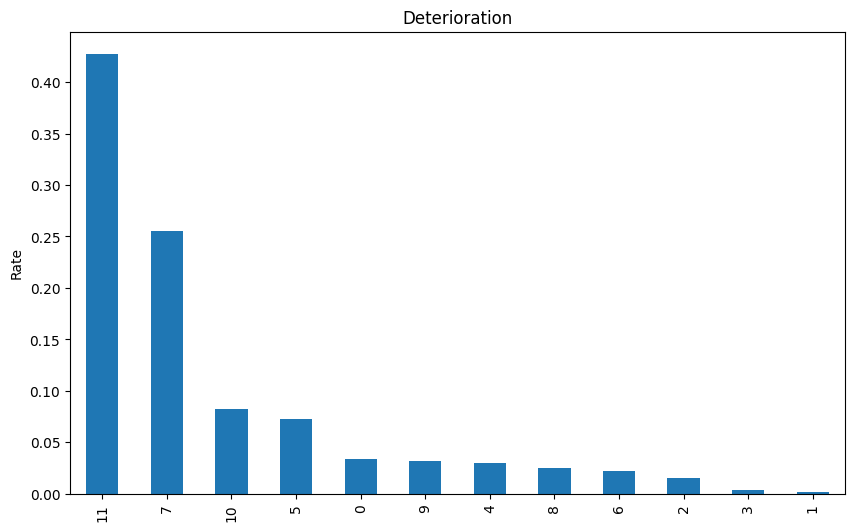

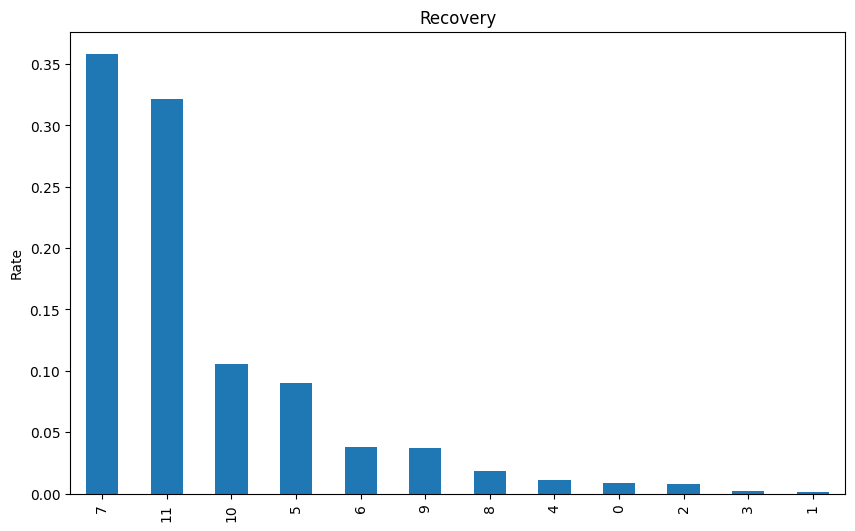

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# det_df의 Action 비율
det_action_counts = det_df[det_df['Annotation']=='circ']['Action_nonseptic'].value_counts(normalize=True)
det_action_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Deterioration')
plt.ylabel('Rate')
plt.show()

# re_df의 Action 비율
re_action_counts = re_df[re_df['Annotation']=='circ']['Action_nonseptic'].value_counts(normalize=True)
re_action_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Recovery')
plt.ylabel('Rate')
plt.show()

In [92]:
# 통계적으로 유의미 하지 않다 -> 치료 정책의 차이가 없다.
from scipy import stats

# Mann-Whitney U test
u_stat, p_val_mw = stats.mannwhitneyu(re_action_counts, det_action_counts)
print("Mann-Whitney U test p-value:", p_val_mw)

# 95% 신뢰 구간 계산
diff = re_action_counts - det_action_counts
ci = np.percentile(diff, [2.5, 97.5])

print("95% 신뢰 구간:", ci)

Mann-Whitney U test p-value: 0.8398599725400034
95% 신뢰 구간: [-0.08393695  0.0810962 ]


In [11]:
make_plot = pd.concat([det_df[det_df['Annotation']=='circ'].iloc[:,221:261], re_df[re_df['Annotation']=='circ'].iloc[:,221:261]])

In [12]:
import umap
import pandas as pd
import numpy as np
reducer_ori = umap.UMAP()
umap_emb_ori = reducer_ori.fit_transform(make_plot)

c:\Users\DAHS\anaconda3\envs\Umap_python\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\DAHS\anaconda3\envs\Umap_python\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\DAHS\anaconda3\envs\Umap_python\lib\site-packages\umap\distances.py:108

In [13]:
make_class = pd.concat([det_df[det_df['Annotation']=='circ'][['classes']], re_df[re_df['Annotation']=='circ'][['classes']]])

In [14]:
umap_emb_ori_df = pd.DataFrame(umap_emb_ori, columns = ['component 0', 'component 1'], index = make_plot.index)
umap_emb_ori_df['classes'] = make_class['classes'].values

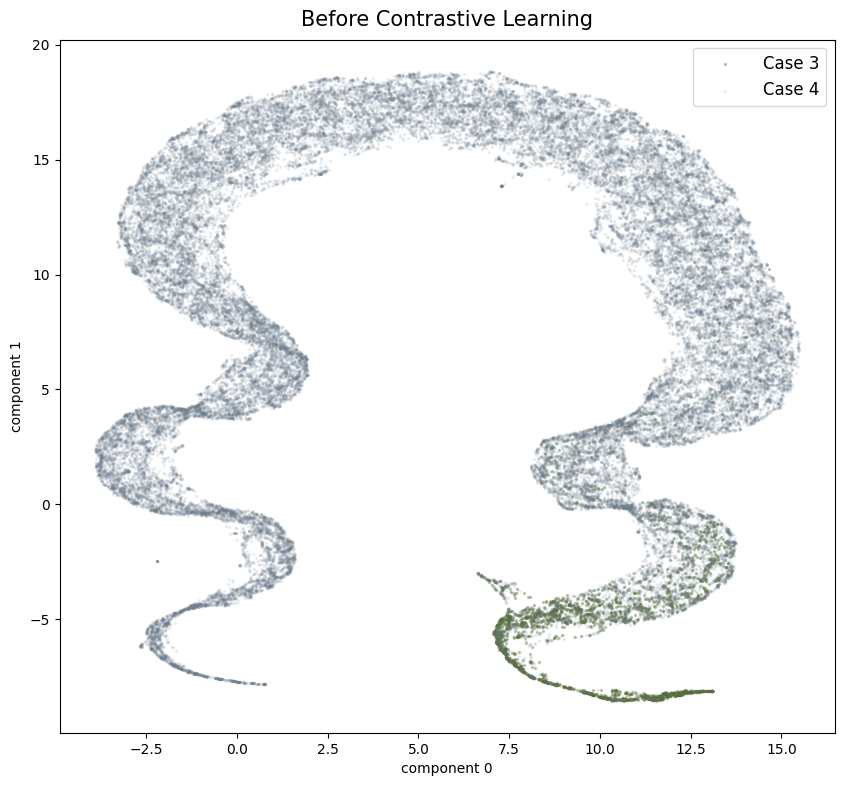

In [15]:
# target 별
plt.rcParams["figure.figsize"] = (10,9)
# 분리
b_tsne_df_2 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 2]
b_tsne_df_3 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 3]

# target 별 시각화
plt.scatter(b_tsne_df_2['component 0'], b_tsne_df_2['component 1'], color = 'darkolivegreen',label = 'Case 3', s=2, alpha=0.3)
plt.scatter(b_tsne_df_3['component 0'], b_tsne_df_3['component 1'], color = 'slategray', label = 'Case 4', s=2, alpha=0.1)

plt.title('Before Contrastive Learning', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()

In [16]:
det_df['label'] = 'det'
re_df['label'] = 'rec'
total_plot = pd.concat([det_df[det_df['Annotation']=='circ'], re_df[re_df['Annotation']=='circ']])

In [17]:
reset_total = pd.concat([total_plot, umap_emb_ori_df.drop('classes', axis = 1)], axis = 1)

In [18]:
new_det_df = reset_total[reset_total['label']=='det']
new_re_df = reset_total[reset_total['label']=='rec']

In [19]:
new_re_df[new_re_df['stay_id']==new_re_df.stay_id.unique()[35]][['Time_since_ICU_admission', 'Action_nonseptic', 'Annotation', 'classes', 'Lactate','MAP', 'Lactate_3', 'MAP_3',
                                                                'Lactate_5', 'MAP_5', 'Lactate_8', 'MAP_8', 'Lactate_12', 'MAP_12']]

,Time_since_ICU_admission,Action_nonseptic,Annotation,classes,Lactate,MAP,Lactate_3,MAP_3,Lactate_5,MAP_5,Lactate_8,MAP_8,Lactate_12,MAP_12
105754,4,7,circ,3,2.9,86.333333,1.8,-5.333333,0.0,0.000000,0.0,0.000000,0.0,0.000000
105755,5,7,circ,3,2.9,78.000000,1.8,-13.666667,1.8,-13.666667,0.0,0.000000,0.0,0.000000
105756,6,7,circ,3,2.9,75.583333,0.0,-16.083333,1.8,-16.083333,0.0,0.000000,0.0,0.000000
105757,7,7,circ,3,2.9,67.833333,0.0,-18.500000,1.8,-23.833333,0.0,0.000000,0.0,0.000000
105758,8,7,circ,3,2.9,77.777778,0.0,-0.222222,0.0,-13.888889,1.8,-13.888889,0.0,0.000000
105759,9,7,circ,3,2.9,77.666667,0.0,2.083333,0.0,-8.666667,1.8,-14.000000,0.0,0.000000
105760,10,5,circ,3,2.9,68.666667,0.0,0.833333,0.0,-9.333333,1.8,-23.000000,0.0,0.000000
105761,11,5,circ,3,2.9,71.888889,0.0,-5.888889,0.0,-3.694444,0.0,-19.777778,0.0,0.000000
105762,12,5,circ,3,2.9,72.000000,0.0,-5.666667,0.0,4.166667,0.0,-14.333333,1.8,-19.666667
105763,13,1,circ,3,2.9,72.666667,0.0,4.000000,0.0,-5.111111,0.0,-5.333333,1.8,-19.000000


In [20]:
exampe = new_re_df[((new_re_df['Lactate_3']<0) & (new_re_df['MAP_3']>0) | (new_re_df['Lactate_5']<0) & (new_re_df['MAP_5']>0) |
               (new_re_df['Lactate_3']<0) & (new_re_df['MAP_5']>0)| (new_re_df['Lactate_5']<0) & (new_re_df['MAP_3']>0)|
               (new_re_df['Lactate_8']<0) & (new_re_df['MAP_3']>0)| (new_re_df['Lactate_8']<0)& (new_re_df['MAP_5']>0)|
               (new_re_df['Lactate_3']<0) & (new_re_df['MAP_8']>0)| (new_re_df['Lactate_5']<0)& (new_re_df['MAP_8']>0)|
               (new_re_df['Lactate_12']<0) & (new_re_df['MAP_8']>0)| (new_re_df['Lactate_12']<0)& (new_re_df['MAP_8']>0)|
               (new_re_df['Lactate_12']<0) & (new_re_df['MAP_5']>0)| (new_re_df['Lactate_12']<0)& (new_re_df['MAP_5']>0)|
               (new_re_df['Lactate_12']<0) & (new_re_df['MAP_3']>0)| (new_re_df['Lactate_12']<0)& (new_re_df['MAP_3']>0)|
               (new_re_df['Lactate_3']<0) & (new_re_df['MAP_12']>0)| (new_re_df['Lactate_3']<0)& (new_re_df['MAP_12']>0)|
               (new_re_df['Lactate_5']<0) & (new_re_df['MAP_12']>0)| (new_re_df['Lactate_5']<0)& (new_re_df['MAP_12']>0)|
               (new_re_df['Lactate_8']<0) & (new_re_df['MAP_12']>0)| (new_re_df['Lactate_8']<0)& (new_re_df['MAP_12']>0)) & (new_re_df['classes']==2)].stay_id.unique()

In [21]:
new_re_df[new_re_df['stay_id']==exampe[1]][['Time_since_ICU_admission', 'Action_nonseptic', 'Annotation', 'classes', 'Lactate','MAP', 'Lactate_3', 'MAP_3',
                                                                'Lactate_5', 'MAP_5', 'Lactate_8', 'MAP_8', 'Lactate_12', 'MAP_12']]

,Time_since_ICU_admission,Action_nonseptic,Annotation,classes,Lactate,MAP,Lactate_3,MAP_3,Lactate_5,MAP_5,Lactate_8,MAP_8,Lactate_12,MAP_12
9927,3,11,circ,3,2.6,80.166667,1.5,-11.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000
9928,4,7,circ,3,2.6,71.333333,1.5,-20.333333,0.0,0.000000,0.0,0.000000,0.0,0.000000
9929,5,7,circ,3,4.9,71.250000,2.3,-23.750000,3.8,-20.416667,0.0,0.000000,0.0,0.000000
9930,6,7,circ,3,4.9,76.222222,2.3,-3.944444,3.8,-15.444444,0.0,0.000000,0.0,0.000000
9931,7,7,circ,3,5.1,64.000000,2.5,-7.333333,2.5,-31.000000,0.0,0.000000,0.0,0.000000
9932,8,7,circ,3,4.7,74.166667,-0.2,2.916667,2.1,-6.000000,3.6,-17.500000,0.0,0.000000
9933,9,7,circ,3,4.7,73.666667,-0.2,-2.555556,2.1,2.333333,3.6,-18.000000,0.0,0.000000
9934,10,11,circ,3,4.7,81.000000,-0.4,17.000000,-0.2,9.750000,2.1,-14.000000,0.0,0.000000
9935,11,7,circ,3,4.7,81.333333,0.0,7.166667,-0.2,5.111111,2.1,1.166667,0.0,0.000000
9936,12,7,circ,3,4.7,77.666667,0.0,4.000000,-0.4,13.666667,2.1,6.333333,3.6,-14.000000


In [ ]:
# 973 stay 중 542개 

In [39]:
sample = new_re_df[new_re_df['stay_id'].isin(exampe)]

In [54]:
dd = pd.DataFrame()

for stay in sample.stay_id.unique():
    
    df = sample[sample['stay_id']==stay]

    # classes가 2가 되기 직전에 해당하는 인덱스를 찾기
    start_index = df[df['classes'] == 2].index[0] - 3

    # 필요한 부분만 잘라내기
    trimmed_df = df.loc[start_index:][['stay_id','Time_since_ICU_admission', 'Action_nonseptic', 'Annotation', 'classes', 'Lactate','MAP', 'Lactate_3', 'MAP_3',
                                                                'Lactate_5', 'MAP_5', 'Lactate_8', 'MAP_8', 'Lactate_12', 'MAP_12', 'component 0', 'component 1']]
    dd = pd.concat([dd, trimmed_df], axis = 0)

In [75]:
sample.stay_id.unique()[18]

30394297

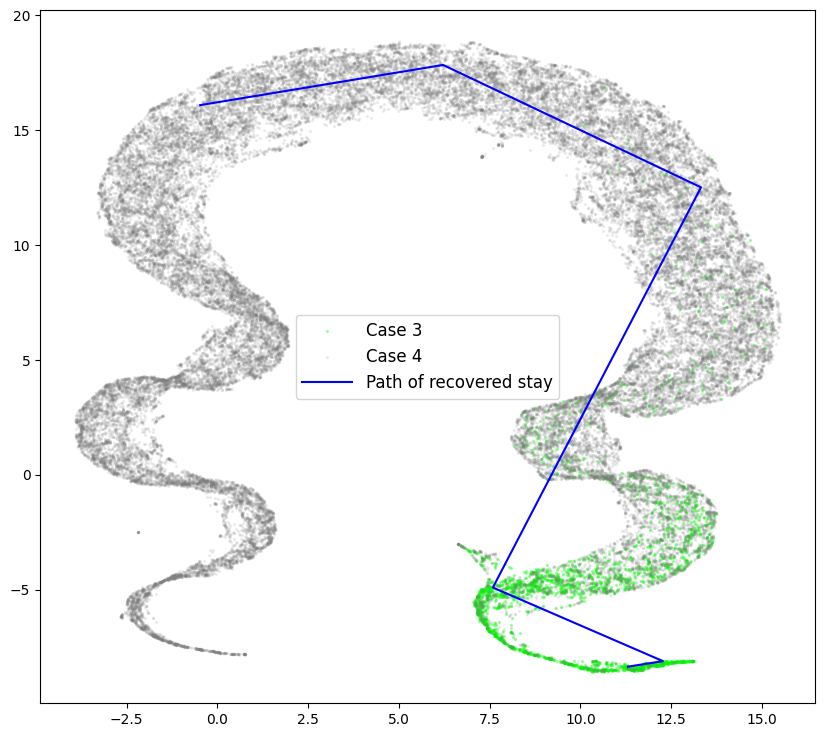

In [143]:
# target 별
plt.rcParams["figure.figsize"] = (10,9)
# 분리
b_tsne_df_2 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 2]
b_tsne_df_3 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 3]

# target 별 시각화
plt.scatter(b_tsne_df_2['component 0'], b_tsne_df_2['component 1'], color = 'lime',label = 'Case 3', s=2, alpha=0.3)
plt.scatter(b_tsne_df_3['component 0'], b_tsne_df_3['component 1'], color = 'grey', label = 'Case 4', s=2, alpha=0.1)

plt.plot(dd[dd['stay_id']==sample.stay_id.unique()[18]].iloc[-6:]['component 0'], dd[dd['stay_id']==sample.stay_id.unique()[18]].iloc[-6:]['component 1'],
         color = 'blue', label = 'Path of recovered stay')
plt.legend(fontsize=12, handlelength=3)
plt.show()

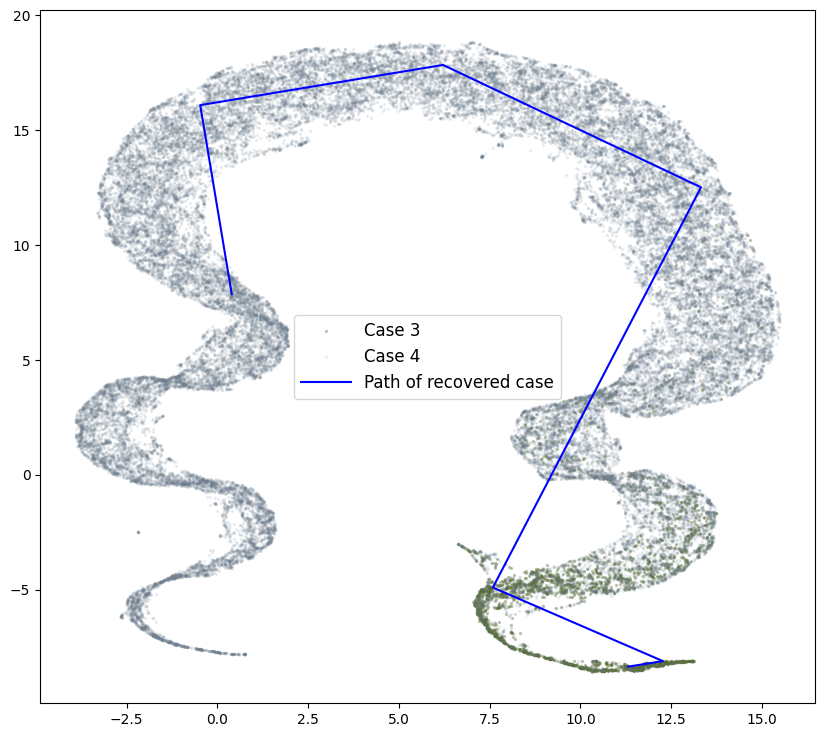

In [90]:
# target 별
plt.rcParams["figure.figsize"] = (10,9)
# 분리
b_tsne_df_2 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 2]
b_tsne_df_3 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 3]

# target 별 시각화
plt.scatter(b_tsne_df_2['component 0'], b_tsne_df_2['component 1'], color = 'darkolivegreen',label = 'Case 3', s=2, alpha=0.3)
plt.scatter(b_tsne_df_3['component 0'], b_tsne_df_3['component 1'], color = 'slategray', label = 'Case 4', s=2, alpha=0.1)

plt.plot(new_re_df[new_re_df['stay_id']==sample.stay_id.unique()[18]].iloc[-7:]['component 0'], new_re_df[new_re_df['stay_id']==sample.stay_id.unique()[18]].iloc[-7:]['component 1'],
         color = 'blue', label = 'Path of recovered case')

plt.legend(fontsize=12, handlelength=3)
plt.show()

In [106]:
new_re_df[new_re_df['stay_id']==sample.stay_id.unique()[18]][['stay_id','Time_since_ICU_admission', 'Action_nonseptic', 'Annotation', 'classes', 'Lactate','MAP', 'Lactate_3', 'MAP_3',
                                                                'Lactate_5', 'MAP_5', 'Lactate_8', 'MAP_8', 'Lactate_12', 'MAP_12']]

,stay_id,Time_since_ICU_admission,Action_nonseptic,Annotation,classes,Lactate,MAP,Lactate_3,MAP_3,Lactate_5,MAP_5,Lactate_8,MAP_8,Lactate_12,MAP_12
84178,30394297,4,7,circ,3,2.30,63.666667,1.00,-28.000000,0.00,0.000000,0.00,0.000000,0.0,0.000000
84179,30394297,5,7,circ,3,2.30,77.000000,1.00,-14.666667,1.00,-14.666667,0.00,0.000000,0.0,0.000000
84180,30394297,6,11,circ,3,2.30,71.000000,0.00,2.333333,1.00,-20.666667,0.00,0.000000,0.0,0.000000
84181,30394297,7,11,circ,3,5.15,72.500000,2.85,8.833333,3.85,-19.166667,0.00,0.000000,0.0,0.000000
84182,30394297,8,7,circ,3,6.70,72.500000,4.40,-4.500000,4.40,3.833333,5.40,-19.166667,0.0,0.000000
84183,30394297,9,7,circ,3,6.70,73.666667,4.40,2.666667,4.40,10.000000,5.40,-18.000000,0.0,0.000000
84184,30394297,10,6,circ,3,5.30,66.000000,0.15,-6.500000,3.00,-11.000000,4.00,-25.666667,0.0,0.000000
84185,30394297,14,7,circ,2,2.30,62.666667,-3.00,-25.000000,-4.40,-11.000000,0.00,-8.333333,1.0,-29.000000
84186,30394297,15,6,circ,2,2.30,95.666667,0.00,8.000000,-3.00,29.666667,-2.85,23.166667,0.0,27.000000
84187,30394297,16,7,circ,2,1.60,86.333333,-0.70,-1.333333,-3.70,-1.333333,-5.10,13.833333,-0.7,22.666667


In [100]:
(2.3 - 1.6) /  2.30

0.30434782608695643

In [104]:
0.367960 / 2.281450

0.16128339433255168

In [105]:
0.422719/ 2.281450

0.1852852352670451

In [84]:
dd[dd['classes']==2].describe()

,stay_id,Time_since_ICU_admission,Action_nonseptic,classes,Lactate,MAP,Lactate_3,MAP_3,Lactate_5,MAP_5,Lactate_8,MAP_8,Lactate_12,MAP_12,component 0,component 1
count,1.779000e+03,1779.000000,1779.000000,1779.0,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000
mean,3.515212e+07,75.528387,7.411467,2.0,2.281450,73.462037,-0.367960,0.305739,-0.422719,-0.999298,-0.431900,-2.204346,-0.291428,-3.505515,10.226764,-4.516945
std,2.831688e+06,110.908690,2.416061,0.0,0.797921,10.185252,0.814036,10.396801,1.050979,11.186325,1.340158,12.839159,1.494055,13.660413,2.008081,3.767179
min,3.000360e+07,3.000000,0.000000,2.0,0.700000,50.000000,-6.600000,-49.333333,-6.600000,-49.500000,-9.500000,-59.000000,-9.100000,-53.333333,6.722792,-8.573642
25%,3.268406e+07,15.000000,6.000000,2.0,1.900000,66.000000,-0.700000,-5.000000,-0.900000,-7.333333,-0.900000,-9.666667,-0.800000,-12.333333,8.439323,-7.825337
50%,3.525838e+07,29.000000,7.000000,2.0,2.200000,72.666667,0.000000,0.333333,0.000000,0.000000,-0.100000,-1.000000,0.000000,-1.000000,10.247819,-4.966520
75%,3.767656e+07,81.000000,9.000000,2.0,2.600000,79.666667,0.000000,6.333333,0.000000,5.666667,0.100000,5.333333,0.400000,4.333333,11.964259,-3.561660
max,3.999019e+07,675.000000,11.000000,2.0,8.100000,119.666667,5.400000,46.000000,5.400000,55.000000,5.500000,49.000000,6.200000,58.333333,15.238302,16.877857


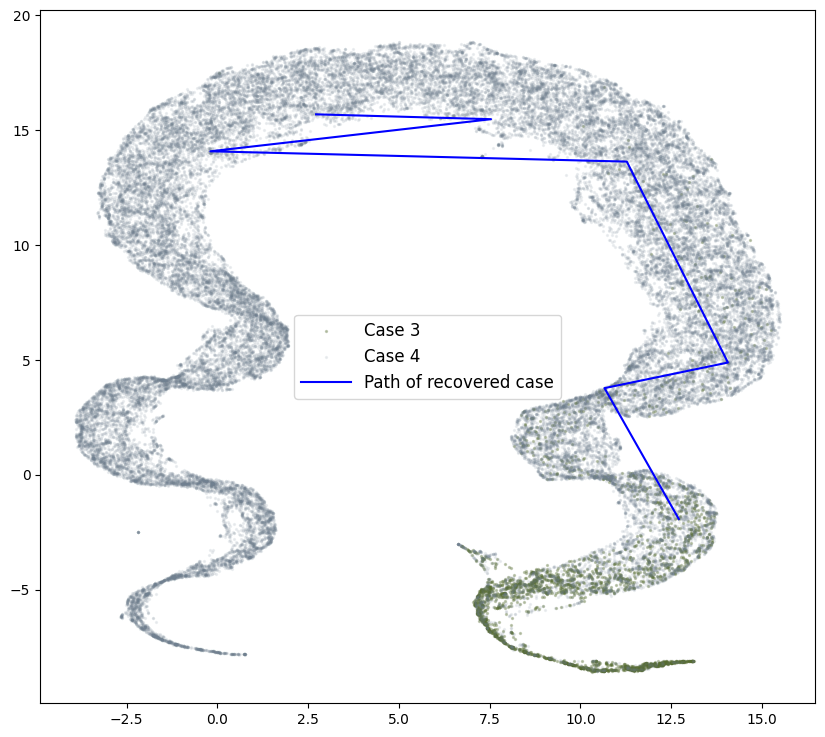

In [101]:
# target 별
plt.rcParams["figure.figsize"] = (10,9)
# 분리
b_tsne_df_2 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 2]
b_tsne_df_3 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 3]

# target 별 시각화
plt.scatter(b_tsne_df_2['component 0'], b_tsne_df_2['component 1'], color = 'darkolivegreen',label = 'Case 3', s=2, alpha=0.3)
plt.scatter(b_tsne_df_3['component 0'], b_tsne_df_3['component 1'], color = 'slategray', label = 'Case 4', s=2, alpha=0.1)

plt.plot(new_re_df[new_re_df['stay_id']==sample.stay_id.unique()[28]].iloc[-7:]['component 0'], new_re_df[new_re_df['stay_id']==sample.stay_id.unique()[28]].iloc[-7:]['component 1'],
         color = 'blue', label = 'Path of recovered case')

plt.legend(fontsize=12, handlelength=3)
plt.show()

In [148]:
new_re_df[new_re_df['stay_id']==sample.stay_id.unique()[18]].iloc[-7:][['stay_id','Time_since_ICU_admission', 'Action_nonseptic', 'Annotation', 'classes', 'Lactate','MAP', 'Lactate_3', 'MAP_3',
                                                                'Lactate_5', 'MAP_5', 'Lactate_8', 'MAP_8', 'Lactate_12', 'MAP_12']]

,stay_id,Time_since_ICU_admission,Action_nonseptic,Annotation,classes,Lactate,MAP,Lactate_3,MAP_3,Lactate_5,MAP_5,Lactate_8,MAP_8,Lactate_12,MAP_12
84181,30394297,7,11,circ,3,5.15,72.500000,2.85,8.833333,3.85,-19.166667,0.00,0.000000,0.0,0.000000
84182,30394297,8,7,circ,3,6.70,72.500000,4.40,-4.500000,4.40,3.833333,5.40,-19.166667,0.0,0.000000
84183,30394297,9,7,circ,3,6.70,73.666667,4.40,2.666667,4.40,10.000000,5.40,-18.000000,0.0,0.000000
84184,30394297,10,6,circ,3,5.30,66.000000,0.15,-6.500000,3.00,-11.000000,4.00,-25.666667,0.0,0.000000
84185,30394297,14,7,circ,2,2.30,62.666667,-3.00,-25.000000,-4.40,-11.000000,0.00,-8.333333,1.0,-29.000000
84186,30394297,15,6,circ,2,2.30,95.666667,0.00,8.000000,-3.00,29.666667,-2.85,23.166667,0.0,27.000000
84187,30394297,16,7,circ,2,1.60,86.333333,-0.70,-1.333333,-3.70,-1.333333,-5.10,13.833333,-0.7,22.666667


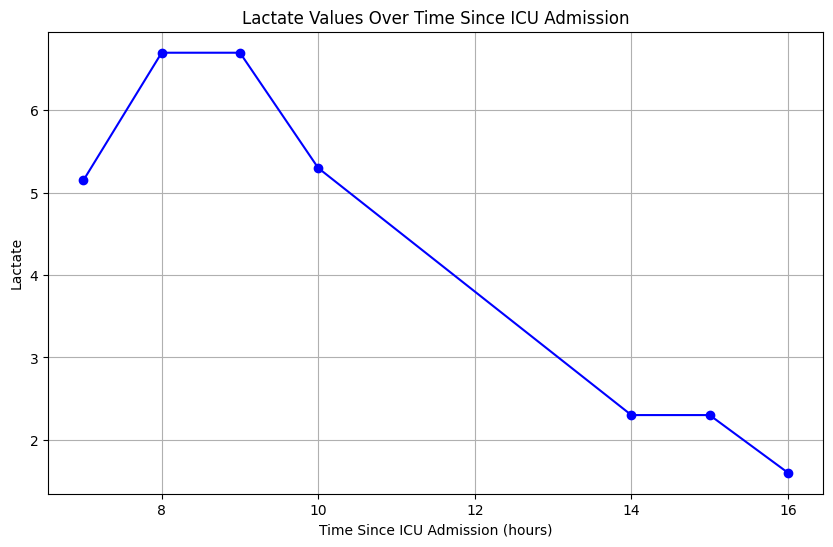

In [149]:
import matplotlib.pyplot as plt

# 데이터프레임에서 필요한 열을 추출합니다.
subset_df = new_re_df[new_re_df['stay_id'] == sample.stay_id.unique()[18]].iloc[-7:]
time_since_icu_admission = subset_df['Time_since_ICU_admission']
lactate_values = subset_df['Lactate']

# 시간에 따른 Lactate 값의 변화를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.plot(time_since_icu_admission, lactate_values, marker='o', linestyle='-', color='b')
plt.title('Lactate Values Over Time Since ICU Admission')
plt.xlabel('Time Since ICU Admission (hours)')
plt.ylabel('Lactate')
plt.grid(True)
plt.show()


In [132]:
lactate_dicrease = []

for stay in sample.stay_id.unique():
    
    df = new_re_df[new_re_df['stay_id']==stay]

    # classes가 2가 되기 직전에 해당하는 인덱스를 찾기
    try:
        start_index = df[df['classes'] == 3].index[-2] 
    except:
        start_index = df[df['classes'] == 2].index[0] 
    end_index = df[df['classes'] == 2].index[-1] 
    
    lactate = ((df['Lactate'].loc[start_index] - df['Lactate'].loc[end_index]) / df['Lactate'].loc[start_index]) * 100
    
    lactate_dicrease.append(lactate)

In [133]:
lactate_dicrease_det = []

for stay in new_det_df.stay_id.unique():
    
    df = new_det_df[new_det_df['stay_id']==stay]

    # classes가 2가 되기 직전에 해당하는 인덱스를 찾기
    start_index = df[df['classes'] == 3].index[-3] 
    end_index = df[df['classes'] == 3].index[-1] 
    
    lactate = ((df['Lactate'].loc[start_index] - df['Lactate'].loc[end_index]) / df['Lactate'].loc[start_index]) * 100
    
    lactate_dicrease_det.append(lactate)

In [134]:
sum(lactate_dicrease_det)/len(lactate_dicrease_det)

3.2518756161128723

In [137]:
len(lactate_dicrease_det)

427

In [136]:
len(lactate_dicrease)

583

In [135]:
sum(lactate_dicrease)/len(lactate_dicrease)

32.922932576129355

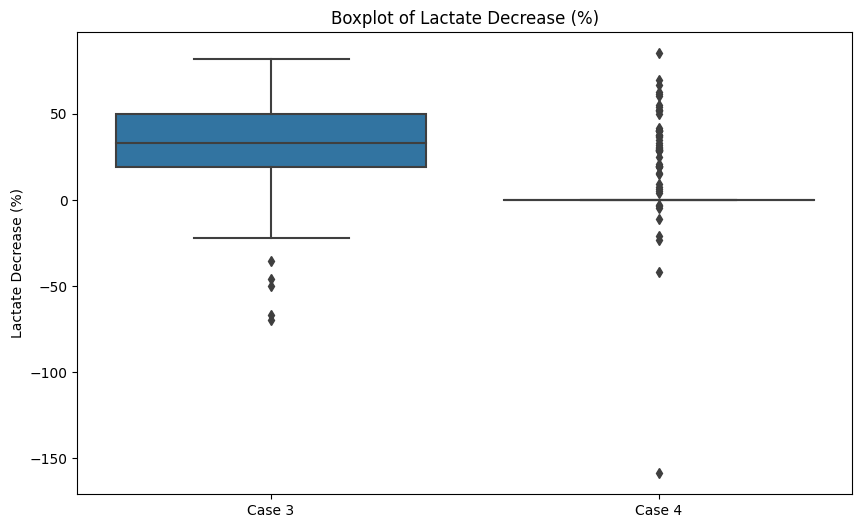

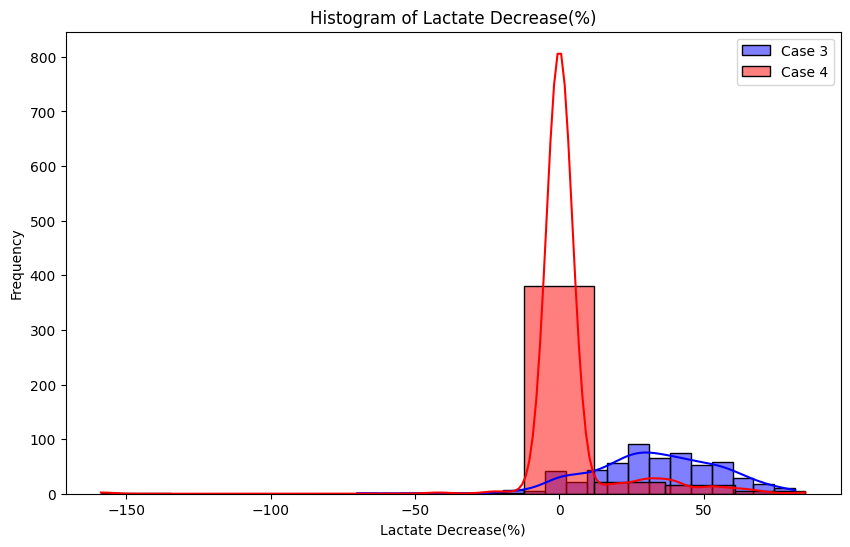

(25.224068321982934, 4.138794146961645e-109)

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# 상자 수염 그림(Boxplot) 생성
plt.figure(figsize=(10, 6))
sns.boxplot(data=[lactate_dicrease, lactate_dicrease_det])
plt.xticks([0, 1], ['Case 3', 'Case 4'])
plt.title('Boxplot of Lactate Decrease (%)')
plt.ylabel('Lactate Decrease (%)')
plt.show()

# 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(lactate_dicrease, color='blue', kde=True, label='Case 3')
sns.histplot(lactate_dicrease_det, color='red', kde=True, label='Case 4')
plt.title('Histogram of Lactate Decrease(%)')
plt.xlabel('Lactate Decrease(%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# t-검정 수행
t_stat, p_value = ttest_ind(lactate_dicrease, lactate_dicrease_det, equal_var=False)

t_stat, p_value